### Lab-3 : Self-Practice

#### In this week, your self-practice task will consist to analyze the impact of class imballance on the performance of the logistic regression model.

#### Class imbalance is very common in real life. For example, in a classification problem to predict whether a person has a certain very rare disease, the dataset will always contain more negative samples than positive ones. This situation can have a significant impact on the performance of the model. You will analyze this situation in the case of the Titanic dataset used in the lab.

### 1. Load the titanic dataset and <b>PLOT</b> the proportion of positive and negative samples (survived vs non survived)

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('titanic.csv')

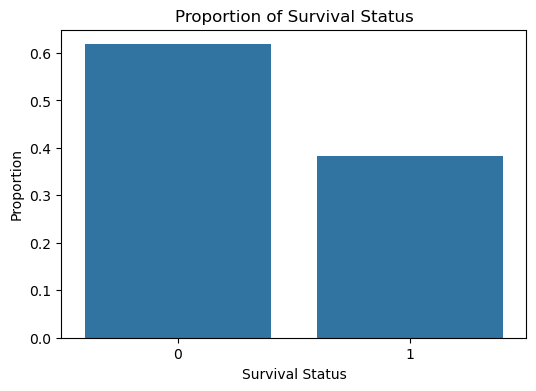

In [3]:
survival_counts = data['survived'].value_counts(normalize=True)

plt.figure(figsize=(6,4))

sns.barplot(x=survival_counts.index, y=survival_counts.values)

plt.xlabel('Survival Status')
plt.ylabel('Proportion')
plt.title('Proportion of Survival Status')
plt.show()


#### Preprocess the data as it has been done in the lab, feel free to adapt

In [4]:
data = data.drop(['name'], axis=1)

In [5]:
imputer = SimpleImputer(strategy='most_frequent')
data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

encoder = OneHotEncoder(sparse_output=False, drop='first')
f_names = ['sex', 'embarked']
encoder.fit(data[f_names])
new_cols = pd.DataFrame(encoder.transform(data[f_names]), columns=encoder.get_feature_names_out(f_names))
data = pd.concat([data, new_cols], axis=1)
data = data.drop(f_names, axis=1)

scaler = MinMaxScaler()
scaler.fit(data)
data = pd.DataFrame(scaler.transform(data), columns=data.columns)

## 2. Impact of class imballance. 
##### Now, you will `artificially` imbalance the dataset. From the original dataset, create different dataset with the following class representations (drop samples from one class): 
##### 1. 20% vs 80%
##### 2. 30% vs 70%
##### 3. 40% vs 60%

## Split each data into train and test set as in the lab; train logistic regression model for each setting and report (PLOT) the accuracy, precision, and recall of each model

In [6]:
def create_imbalanced_df(df, ratio):
    df_minority = df[df['survived'] == 1]
    df_majority = df[df['survived'] == 0]
    df_minority_upsampled = df_minority.sample(int(len(df_majority) * ratio), replace=False)
    df_upsampled = pd.concat([df_majority, df_minority_upsampled], axis=0)
    return df_upsampled

In [7]:
imbalance_ratios = [0.2, 0.3, 0.4]

results = {}
class_accuracies = {}

for ratio in imbalance_ratios:
    imbalanced_data = create_imbalanced_df(data.copy(), ratio)
    data_label = imbalanced_data['survived']
    data_feature = imbalanced_data.drop(['survived'], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(data_feature, data_label, test_size=0.2, random_state=42, stratify=data_label)

    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    yIpred_prob = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[ratio] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

    confusion_matrix_data = confusion_matrix(y_test, y_pred)
    class_accuracy_0 = confusion_matrix_data[0, 0] / (confusion_matrix_data[0, 0] + confusion_matrix_data[0, 1]) if (confusion_matrix_data[0, 0] + confusion_matrix_data[0, 1]) > 0 else 0
    class_accuracy_1 = confusion_matrix_data[1, 1] / (confusion_matrix_data[1, 0] + confusion_matrix_data[1, 1]) if (confusion_matrix_data[1, 0] + confusion_matrix_data[1, 1]) > 0 else 0
    class_accuracies[ratio] = {
        0: class_accuracy_0,
        1: class_accuracy_1
    }


In [8]:
ratios = list(results.keys())
accuracies = [results[ratio]['accuracy'] for ratio in ratios]
precisions = [results[ratio]['precision'] for ratio in ratios]
recalls = [results[ratio]['recall'] for ratio in ratios]
f1_scores = [results[ratio]['f1'] for ratio in ratios]

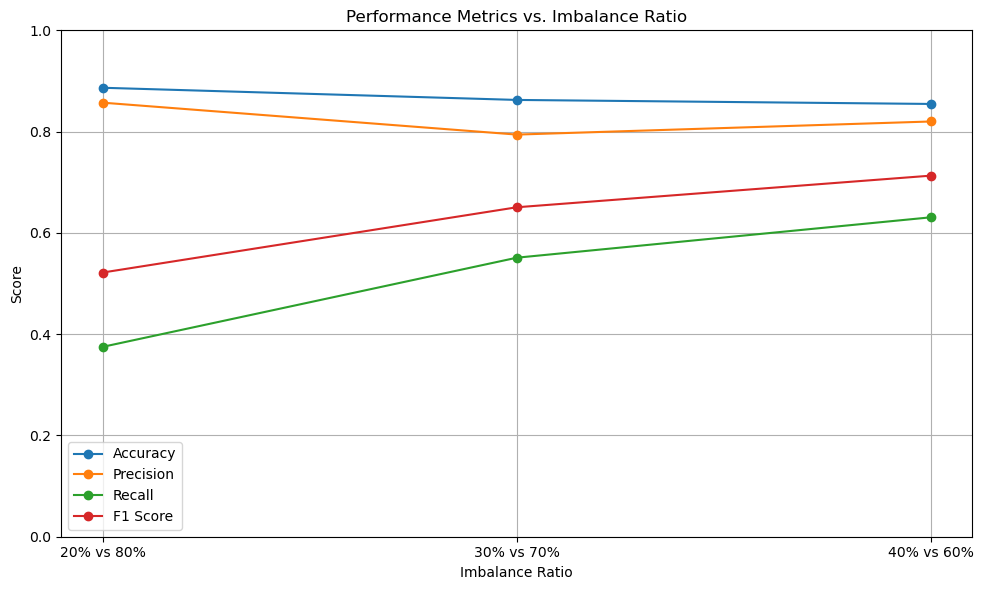

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(ratios, accuracies, marker='o', label='Accuracy')
plt.plot(ratios, precisions, marker='o', label='Precision')
plt.plot(ratios, recalls, marker='o', label='Recall')
plt.plot(ratios, f1_scores, marker='o', label='F1 Score')

plt.xlabel('Imbalance Ratio')
plt.ylabel('Score')
plt.title('Performance Metrics vs. Imbalance Ratio')
plt.xticks(ratios, [f"{ratio*100:.0f}% vs {100-ratio*100:.0f}%" for ratio in ratios])
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


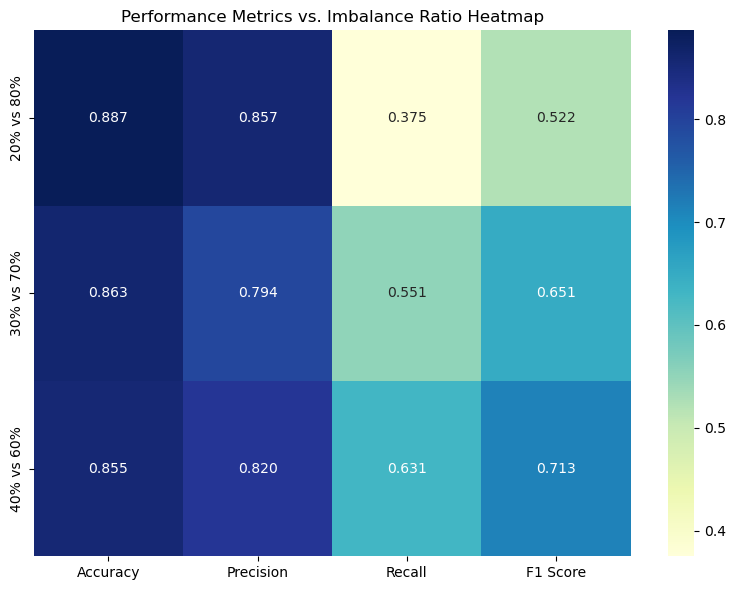

In [10]:
heatmap_data = {'Accuracy': accuracies,
        'Precision': precisions,
        'Recall': recalls,
        'F1 Score': f1_scores}

df = pd.DataFrame(heatmap_data, index=[f"{ratio*100:.0f}% vs {100-ratio*100:.0f}%" for ratio in ratios])

plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Performance Metrics vs. Imbalance Ratio Heatmap')
plt.tight_layout()
plt.show()


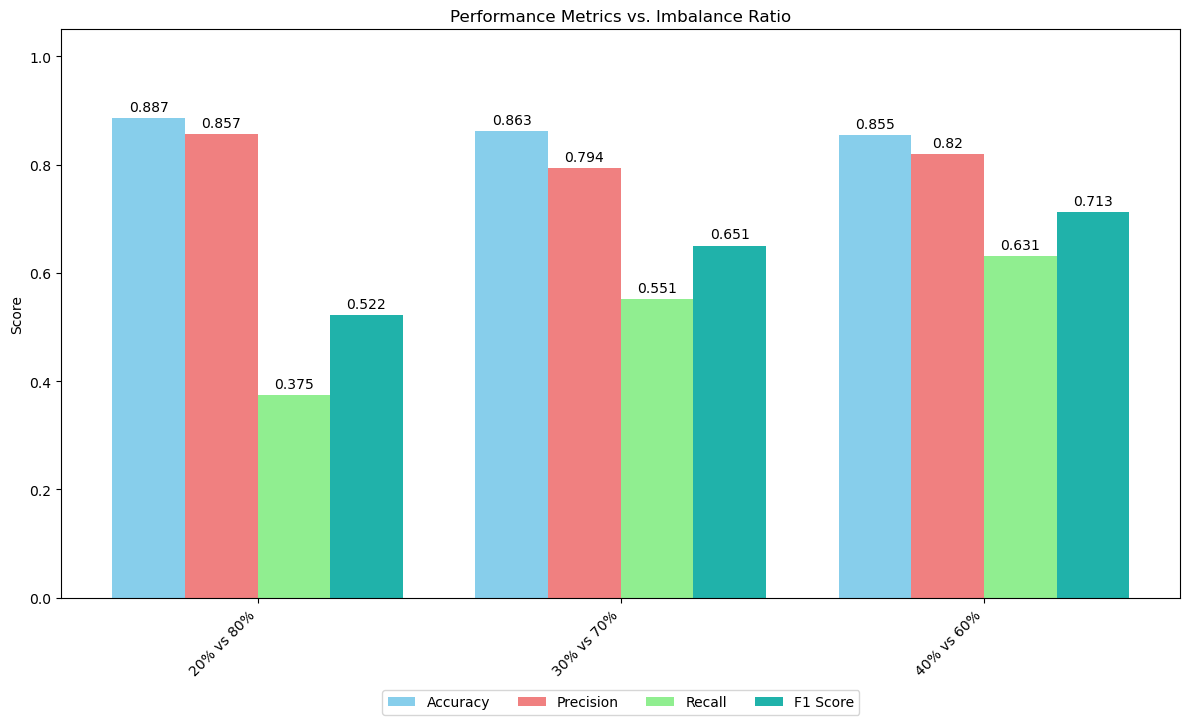

In [11]:
x = np.arange(len(ratios))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='skyblue')
rects2 = ax.bar(x - 0.5*width, precisions, width, label='Precision', color='lightcoral')
rects3 = ax.bar(x + 0.5*width, recalls, width, label='Recall', color='lightgreen')
rects4 = ax.bar(x + 1.5*width, f1_scores, width, label='F1 Score', color='lightseagreen')

ax.set_ylabel('Score')
ax.set_title('Performance Metrics vs. Imbalance Ratio')
ax.set_xticks(x)
ax.set_xticklabels([f"{ratio*100:.0f}% vs {100-ratio*100:.0f}%" for ratio in ratios], rotation=45, ha="right")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax.set_ylim([0, 1.05])

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 3)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)


fig.tight_layout(rect=[0,-0.2,1,1])
plt.show()


## 3. Analyse the class-wise accuracy. 
#### For each model, plot (bar plots) the class-wise accuracy, i.e., the accuracy for each class.

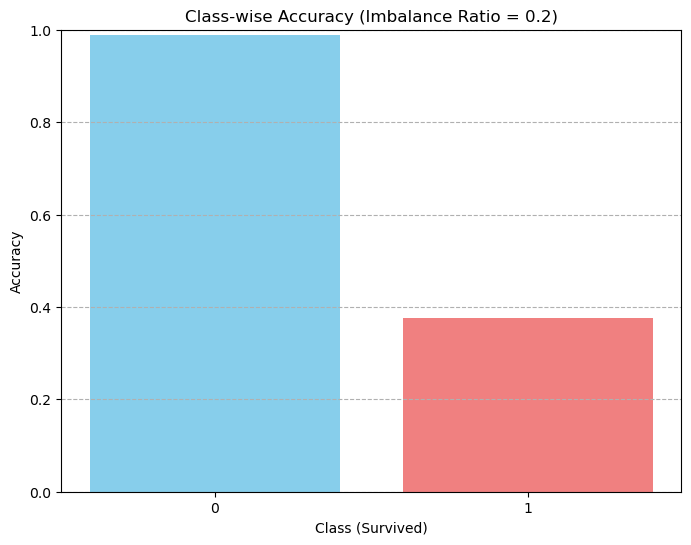

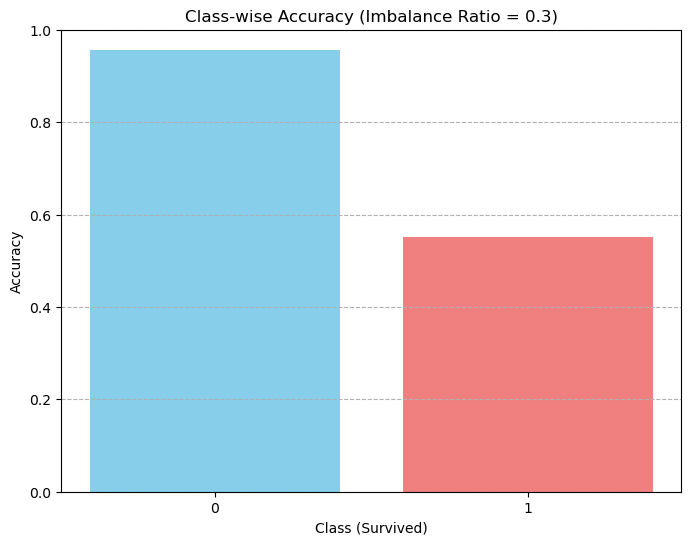

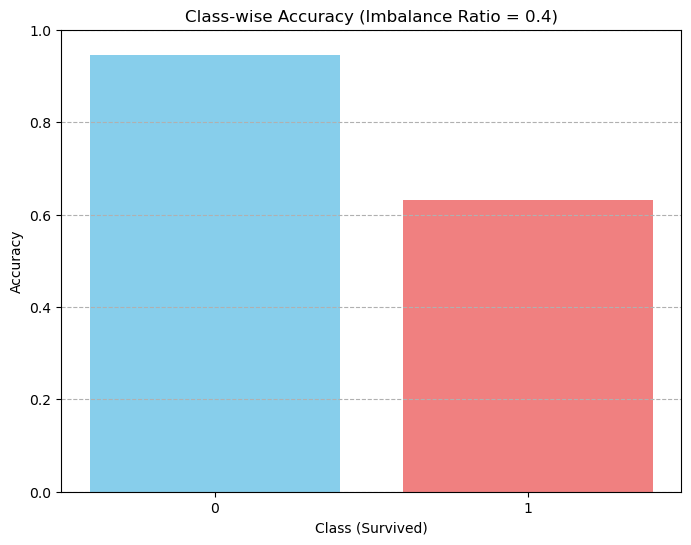

In [12]:
for ratio, accuracies in class_accuracies.items():
    classes = list(accuracies.keys())
    accuracy_values = list(accuracies.values())

    plt.figure(figsize=(8, 6))
    plt.bar(classes, accuracy_values, color=['skyblue', 'lightcoral'])
    plt.xlabel("Class (Survived)")
    plt.ylabel("Accuracy")
    plt.title(f"Class-wise Accuracy (Imbalance Ratio = {ratio})")
    plt.xticks(classes)  # Ensure x-axis labels are the class names
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for accuracy
    plt.grid(axis='y', linestyle='--')
    plt.show()

## 4. Report 
### Write a small report (few sentences) to discuss from your analysis, the impact of class imballance on logistic model's performance 

`Write your report here`